In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.utils.visualisation import *
from src.configs.config import *
from src.configs import config
# from src.utils import learner as lrn
# from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation
# from src.modules import wider_resnet

%load_ext autoreload
%autoreload 2
# # import losses
# # import metrics


In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [1]:
labels = pd.read_csv(os.path.join(PATHS['CSV'], 'train.csv'))
for key in label_names.keys():
    labels[label_names[key]] = 0

labels = labels.apply(fill_targets, axis=1)
labels.head(1)

In [7]:
# focus = ["Lysosomes", "Endosomes"]
# focus = ["Nucleoplasmn"]
focus = ["Endoplasmic reticulum"]

In [8]:
imageloader = TargetGroupIterator(labels, reverse_train_labels, focus, batch_size=4, basepath=PATHS['TRAIN'])
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

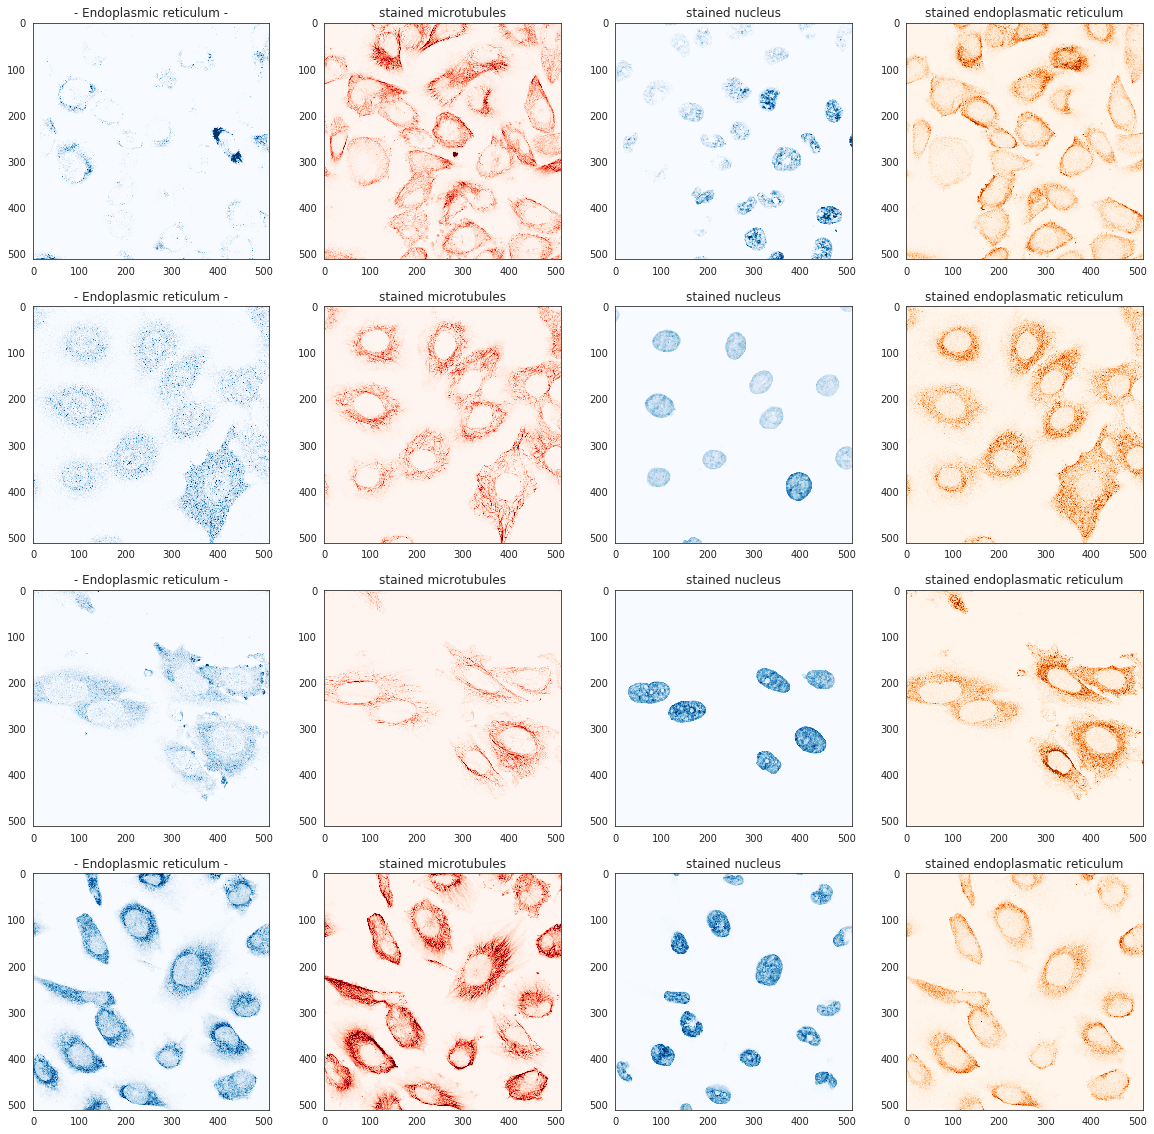

In [24]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids), 4, figsize=(20, 5 * len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(labels, label_names, file_ids[n]))

In [33]:
dataset = ds.ProteinDataset(labels, PATHS['TRAIN'], reverse_train_labels)
means = list()
stds = list()

for data in tqdm(dataset):
    image = data['image'] / 255.
    means.append(image.mean(axis=(0, 1)))
    stds.append(image.std(axis=(0, 1)))
    break

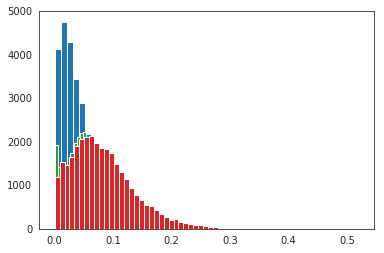

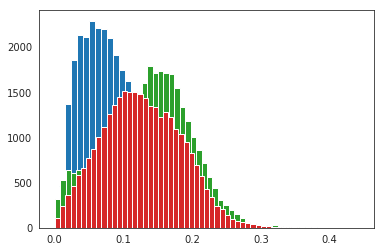

In [26]:
for i in range(4):
    means = np.array(means);
    plt.hist(means[:, i], 50);
plt.show()
for i in range(4):
    stds = np.array(stds);
    plt.hist(stds[:, i], 50);

In [5]:
import os


def create_dir(path):
    try:
        os.mkdir(path)
        print('Directory created: {}'.format(path))
    except:
        print('Directory exists: {}'.format(path))


def init_history(path):
        if os.path.isfile(path):
            return pickle.load(open(path, 'rb'))
        else:
            return defaultdict(list)


def format_predictions(results):
    predictions = np.concatenate([r['prediction'] for r in results])
#     predictions = torch.sigmoid(torch.tensor(predictions))
    labels = np.concatenate([r['label'] for r in results])
    loss = np.concatenate([r['loss'].reshape(1) for r in results])
    f1_score = measure_f1(predictions, labels)
    return {
        'predictions': predictions,
        'labels': labels,
        'loss': loss,
        'f1_score': f1_score,
    }

def prepare_data(datagen, nb_samples=PARAMS['NB_INFERS']):
    if isinstance(nb_samples, int):
        nb_samples = range(nb_samples)
    data = [datagen.dataset[i] for i in nb_samples]
    data = datagen.collate_fn(data)
    return data


def measure_f1(predictions, labels, threshs=.5):
    if isinstance(threshs, float):
        threshs = [threshs] * labels.shape[-1]
    return [
        sklearn.metrics.f1_score(labels[:, i], predictions[:, i] > threshs[i]) 
        for i, el in enumerate(label_names_list)
    ]


def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=len(PARAMS['PLOT_KEYS']), figsize=(10 * len(PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

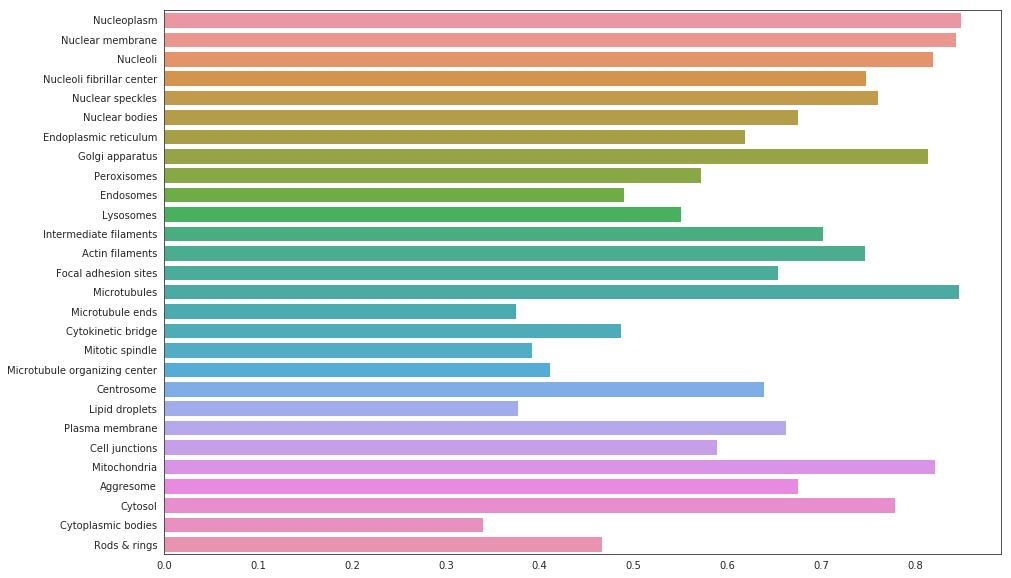

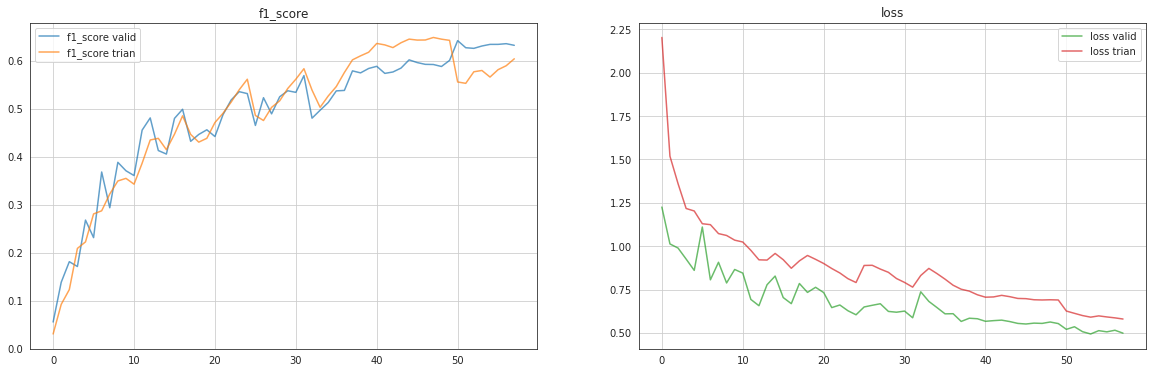

In [28]:
history = pickle.load(open('../data/models/resnet50_pure/fold_0_checkpoint.epoch_loss', 'rb'))
plt.figure(figsize=(15,10))
sns.barplot(y=label_names_list, x=history['valid_losses'][-1]['f1_score']);
plt.show()

formated_train = format_history(history['train_losses'])
formated_valid = format_history(history['valid_losses'])
plot_losses(formated_train, formated_valid)

# Full Size Restoring

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [7]:
import libarchive.public
import os
import cv2
from tqdm import tqdm

import sys
sys.path.append('..')
from src.configs import config

In [3]:
!/home/vessemer/anaconda3/envs/cxr/bin/pip install libarchive

In [27]:
root_path = '../data/train_full_size/'
shrinked_shape = config.PARAMS['SHRINKED_FULL_SIZE']
shrinked_shape = (shrinked_shape, shrinked_shape)

In [5]:
skipped = list()

with libarchive.public.file_reader('/home/vessemer/Projects/train_full_size.7z') as e:
    for entry in tqdm(e):
        path = os.path.join(root_path, entry.pathname)
        try:
            with open(path, 'wb') as f:
                for block in entry.get_blocks():
                    f.write(block)
            image = cv2.imread(path, 0)
            image = cv2.resize(image, shrinked_shape, cv2.INTER_AREA)
            cv2.imwrite(path[:-4] + '.png', image)
            os.remove(path)
        except:
            print(path)
            skipped.append(path)


5319it [20:33,  4.31it/s]

../data/train_full_size/0afda11a-bba0-11e8-b2b9-ac1f6b6435d0_red.tif


39674it [2:37:58,  4.19it/s]

../data/train_full_size/5297c0e2-bbc2-11e8-b2bb-ac1f6b6435d0_green.tif


47483it [3:10:25,  4.16it/s]

../data/train_full_size/6282fe1e-bbc1-11e8-b2bb-ac1f6b6435d0_red.tif


51371it [3:26:22,  4.15it/s]

../data/train_full_size/6a82276e-bbc8-11e8-b2bc-ac1f6b6435d0_green.tif


52214it [3:29:47,  4.15it/s]

../data/train_full_size/6c6ac5ea-bba0-11e8-b2b9-ac1f6b6435d0_green.tif


60285it [4:03:29,  4.13it/s]

../data/train_full_size/7ccb60c0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.tif


67393it [4:32:31,  4.12it/s]

../data/train_full_size/8ba4bc58-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.tif


81957it [5:35:16,  4.07it/s]

../data/train_full_size/a9125fa6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.tif


91929it [6:16:13,  4.07it/s]

../data/train_full_size/bd7be178-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.tif


115539it [7:55:41,  4.05it/s]

../data/train_full_size/edf568ca-bb9d-11e8-b2b9-ac1f6b6435d0_red.tif


117391it [8:03:16,  4.05it/s]

../data/train_full_size/f1c7702c-bbc7-11e8-b2bc-ac1f6b6435d0_red.tif


122663it [8:25:12,  4.05it/s]

../data/train_full_size/fcde8c06-bbb4-11e8-b2ba-ac1f6b6435d0_red.tif


124288it [8:31:59,  4.05it/s]


In [12]:
paths = [
    '../data/train_full_size/0afda11a-bba0-11e8-b2b9-ac1f6b6435d0_red.tif',
    '../data/train_full_size/5297c0e2-bbc2-11e8-b2bb-ac1f6b6435d0_green.tif',
    '../data/train_full_size/6282fe1e-bbc1-11e8-b2bb-ac1f6b6435d0_red.tif',
    '../data/train_full_size/6a82276e-bbc8-11e8-b2bc-ac1f6b6435d0_green.tif',
    '../data/train_full_size/6c6ac5ea-bba0-11e8-b2b9-ac1f6b6435d0_green.tif',
    '../data/train_full_size/7ccb60c0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.tif',
    '../data/train_full_size/8ba4bc58-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.tif',
    '../data/train_full_size/a9125fa6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.tif',
    '../data/train_full_size/bd7be178-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.tif',
    '../data/train_full_size/edf568ca-bb9d-11e8-b2b9-ac1f6b6435d0_red.tif',
    '../data/train_full_size/f1c7702c-bbc7-11e8-b2bc-ac1f6b6435d0_red.tif',
    '../data/train_full_size/fcde8c06-bbb4-11e8-b2ba-ac1f6b6435d0_red.tif'
]
shrinked = [os.path.join('../data/train/', os.path.basename(p)[:-4] + '.png') for p in paths]
for path, sh_path in zip(paths, shrinked):
    image = cv2.imread(sh_path, 0)
    image = cv2.resize(image, shrinked_shape)
    cv2.imwrite(path[:-4] + '.png', image)

In [ ]:
root_path = '../data/test_full_size/'
skipped = list()

with libarchive.public.file_reader('/home/vessemer/Projects/test_full_size.7z') as e:
    for entry in tqdm(e):
        path = os.path.join(root_path, entry.pathname)
        try:
            with open(path, 'wb') as f:
                for block in entry.get_blocks():
                    f.write(block)
            image = cv2.imread(path, 0)
            image = cv2.resize(image, shrinked_shape, cv2.INTER_AREA)
            cv2.imwrite(path[:-4] + '.png', image)
            os.remove(path)
        except:
            print(path)
            skipped.append(path)


18485it [2:12:01,  2.33it/s]

../data/test_full_size/65bd5f06-bac8-11e8-b2b8-ac1f6b6435d0_blue.tif


29565it [3:46:52,  2.17it/s]

../data/test_full_size/a14399ee-bad4-11e8-b2b8-ac1f6b6435d0_yellow.tif


39296it [5:23:00,  2.03it/s]

../data/test_full_size/d67b7b9a-bac5-11e8-b2b7-ac1f6b6435d0_yellow.tif


40751it [5:41:51,  1.99it/s]

In [41]:
paths = [
    '../data/test_full_size/65bd5f06-bac8-11e8-b2b8-ac1f6b6435d0_blue.tif',
    '../data/test_full_size/a14399ee-bad4-11e8-b2b8-ac1f6b6435d0_yellow.tif',
    '../data/test_full_size/d67b7b9a-bac5-11e8-b2b7-ac1f6b6435d0_yellow.tif',
    '../data/test_full_size/fcb8e0b6-bad6-11e8-b2b9-ac1f6b6435d0_green.tif',
]

shrinked = [os.path.join('../data/test/', os.path.basename(p)[:-4] + '.png') for p in paths]
for path, sh_path in zip(paths, shrinked):
    image = cv2.imread(sh_path, 0)
    image = cv2.resize(image, shrinked_shape)
    cv2.imwrite(path[:-4] + '.png', image)

In [42]:
path[:-4] + '.png'

'../data/test_full_size/fcb8e0b6-bad6-11e8-b2b9-ac1f6b6435d0_green.png'

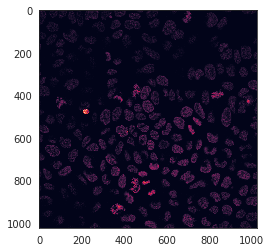

In [25]:
plt.imshow(cv2.imread(path[:-4] + '.png', 0))

# Mingle RGB channels

In [1]:
import cv2

100%|██████████| 31072/31072 [41:26<00:00, 12.50it/s]


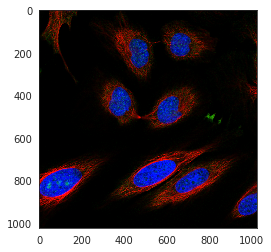

In [20]:
root_dir = '../data/train_full_size/'
colours = ['red', 'green', 'blue']

for path in tqdm(glob(root_dir + '*_blue.png')):
    path = '{}'.join(path.split('blue'))
    image = list()
    for colour in colours:
        image.append(cv2.imread(path.format(colour), 0))
    cv2.imwrite(path.format('blue_red_green'), np.dstack(image))

plt.imshow(np.dstack(image))


100%|██████████| 11702/11702 [00:00<00:00, 197001.51it/s]

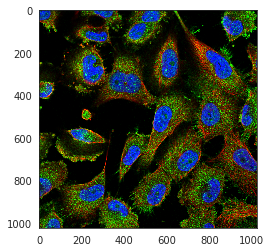

In [44]:
root_dir = '../data/test_full_size/'
colours = ['red', 'green', 'blue']

for path in tqdm(glob(root_dir + '*_blue.png')):
    path = '{}'.join(path.split('blue'))
    if os.path.isfile(path.format('blue_red_green')):
        continue

    image = list()
    for colour in colours:
        image.append(cv2.imread(path.format(colour), 0))
    cv2.imwrite(path.format('blue_red_green'), np.dstack(image))

plt.imshow(np.dstack(image))

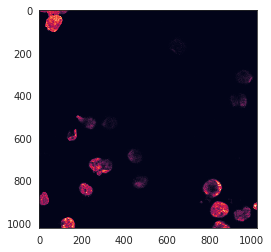

In [70]:
image = cv2.imread('/home/vessemer/Projects/HPA/data/test_full_size_rgb/a865b528-bac9-11e8-b2b8-ac1f6b6435d0_blue_red_green.png')
plt.imshow(image[..., 2])

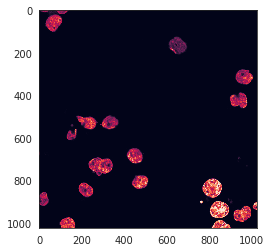

In [71]:
image = cv2.imread('/home/vessemer/Projects/HPA/data/test_full_size_rgb/dc6458f4-bac7-11e8-b2b7-ac1f6b6435d0_blue_red_green.png')
plt.imshow(image[..., 2])

# Augmentations

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa

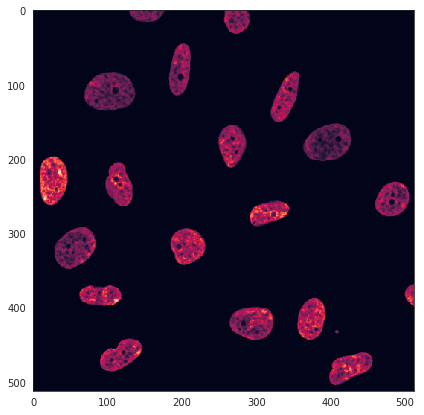

In [46]:
image = cv2.imread('/home/vessemer/Projects/HPA/data/train_shrinked/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue_red_green.png')

plt.figure(figsize=(7, 7))
plt.imshow(image[..., 2])
plt.show()

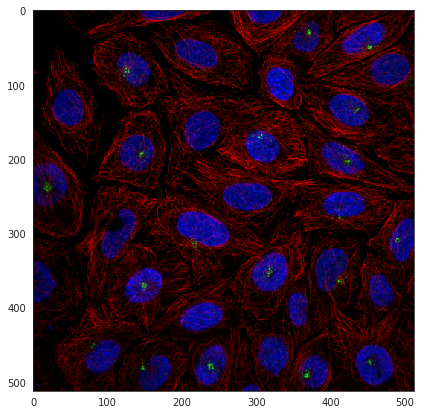

In [11]:
images = image[np.newaxis]

seq = iaa.Sometimes(
    .9,
    iaa.SimplexNoiseAlpha(
        first=iaa.Sometimes(.7, iaa.MedianBlur(k=iaa.Choice([0, 5]))),
        second=iaa.Sometimes(.7, iaa.Multiply(iaa.Choice([0.5, 1.5]), per_channel=False)),
        upscale_method="linear"
    )
)
images_aug = seq.augment_image(image)

plt.figure(figsize=(7, 7))
plt.imshow(images_aug[..., :3])
plt.show()

# Cells Cropping

In [17]:
config.labels.shape

(95307, 30)

In [16]:
config.labels[config.labels.columns[2:]].sum()

Nucleoplasm                      37851
Nuclear membrane                  2644
Nucleoli                          9103
Nucleoli fibrillar center         3168
Nuclear speckles                  4669
Nuclear bodies                    4869
Endoplasmic reticulum             3223
Golgi apparatus                   7341
Peroxisomes                        183
Endosomes                          133
Lysosomes                          116
Intermediate filaments            1804
Actin filaments                   1634
Focal adhesion sites              1071
Microtubules                      2354
Microtubule ends                    39
Cytokinetic bridge                 864
Mitotic spindle                    278
Microtubule organizing center     1445
Centrosome                        2969
Lipid droplets                     336
Plasma membrane                  10668
Cell junctions                    1872
Mitochondria                      8822
Aggresome                          492
Cytosol                  

In [7]:
import shutil


protein = 'Microtubule ends'
# protein = 'Rods & rings'

dst_dit = '../data/tmp/'

ids = config.labels[config.labels[protein] == 1].Id.values
for pid in tqdm(ids):
    name = pid + '_blue_red_green.png'
    src = os.path.join(config.PATHS['TRAIN'], name)
    dst = os.path.join(dst_dit, name)
    shutil.copy(src, dst)

100%|██████████| 39/39 [00:00<00:00, 1592.20it/s]


In [26]:
test = np.load('../data/models/resnet50_pure/test_predicts_fold_0.npy')
valid = np.load('../data/models/resnet50_pure/valid_predicts_fold_0.npy')
labels = np.load('../data/models/resnet50_pure/valid_labels_fold_0.npy')
labels = labels.astype(np.bool_)

In [7]:
data = np.concatenate([valid, test])
data.shape

(30775, 2048)

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=250, 
    n_iter_without_progress=10, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=True, 
    method='barnes_hut', 
    angle=0.5
)

In [11]:
tsne_data = tsne.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30775 samples in 5.140s...
[t-SNE] Computed neighbors for 30775 samples in 2646.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30775
[t-SNE] Computed conditional probabilities for sample 2000 / 30775
[t-SNE] Computed conditional probabilities for sample 3000 / 30775
[t-SNE] Computed conditional probabilities for sample 4000 / 30775
[t-SNE] Computed conditional probabilities for sample 5000 / 30775
[t-SNE] Computed conditional probabilities for sample 6000 / 30775
[t-SNE] Computed conditional probabilities for sample 7000 / 30775
[t-SNE] Computed conditional probabilities for sample 8000 / 30775
[t-SNE] Computed conditional probabilities for sample 9000 / 30775
[t-SNE] Computed conditional probabilities for sample 10000 / 30775
[t-SNE] Computed conditional probabilities for sample 11000 / 30775
[t-SNE] Computed conditional probabilities for sample 12000 / 30775
[t-SNE] Computed conditional probabilities for 

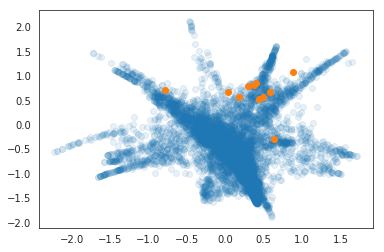

In [32]:
tmp = tsne_data[:len(valid)]
# for idx, el in config.label_names.items():
idx = 0
plt.scatter(tmp[labels[:, idx], 0], tmp[labels[:, idx], 1], alpha=.1)
idx = 27
plt.scatter(tmp[labels[:, idx], 0], tmp[labels[:, idx], 1], alpha=1)

In [24]:
labels


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [5]:
def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=len(PARAMS['PLOT_KEYS']), figsize=(10 * len(PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

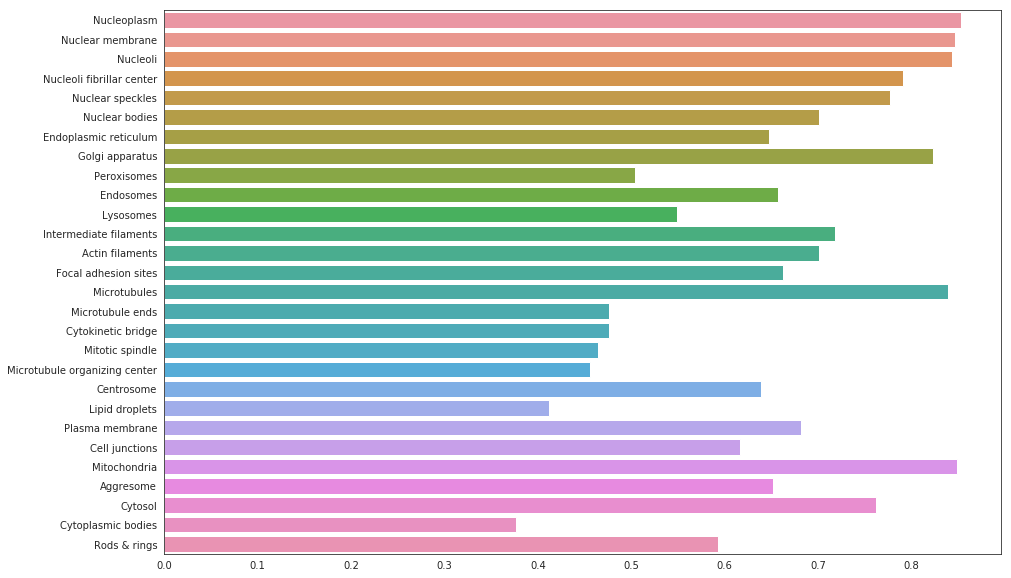

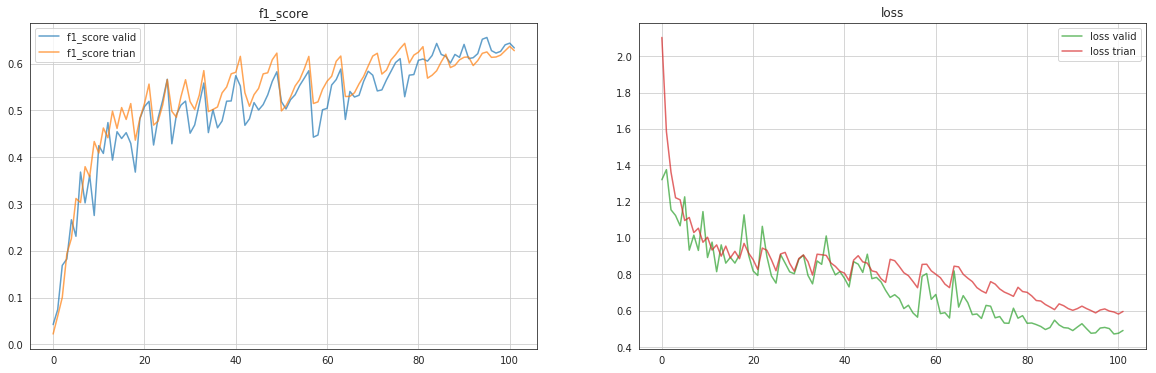

In [14]:
history = pickle.load(open('../data/models/resnet50_pseudo/fold_3_checkpoint.epoch_loss', 'rb'))

formated_train = format_history(history['train_losses'])
formated_valid = format_history(history['valid_losses'])

plt.figure(figsize=(15,10))
sns.barplot(y=label_names_list, x=history['valid_losses'][np.argmax(formated_valid['f1_score'])]['f1_score']);
plt.show()

plot_losses(formated_train, formated_valid)

In [14]:
# history['train_losses'] = history['train_losses'][:-2]
# history['valid_losses'] = history['valid_losses'][:-2]
# pickle.dump(history, open('../data/models/densnet121_side_512/fold_3_checkpoint.epoch_loss', 'wb'))

In [6]:
import numpy_indexed as npi

In [5]:
test_df = pd.read_csv(os.path.join(config.PATHS['CSV'], 'sample_submission.csv'))
for name in config.label_names_list + ['Predicted', 'Target']:
    test_df[name] = 0

In [7]:
checkpoints_pths = ['../data/models/resnet50_pure/', '../data/models/resnet50_pseudo/']

In [8]:
threshs = list()
valid_predicts = list()
valid_labels = list()
predicts = list()
for checkpoints_pth in checkpoints_pths:
    dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
    template_path = 'fold_{}_checkpoint.epoch_{}'
    path = os.path.join(checkpoints_pth, template_path)

    valid_predicts_ = list()
    valid_labels_ = list()
    for fold in range(config.PARAMS['NB_FOLDS']):
        try:
            valid_predicts_.append(np.load(dump_path.format('valid_predicts_old', fold) + '.npy'))
        except:
            valid_predicts_.append(np.load(dump_path.format('valid_predicts', fold) + '.npy'))
        valid_labels_.append(np.load(dump_path.format('valid_labels', fold) + '.npy'))
    valid_predicts.append(np.concatenate(valid_predicts_))
    valid_labels.append(np.concatenate(valid_labels_))

    predicts_ = list()
    for fold in range(config.PARAMS['NB_FOLDS']):
        try:
            predicts_.append(np.load(dump_path.format('test_predicts_old', fold) + '.npy'))
        except:
            predicts_.append(np.load(dump_path.format('test_predicts', fold) + '.npy'))
    predicts_ = np.stack(predicts_)
    predicts.append(predicts_)
    threshs.append(np.load(os.path.join(checkpoints_pth, 'threshs.npy')))
predicts = np.array(predicts)
valid_predicts = np.array(valid_predicts)
valid_labels = np.array(valid_labels)
threshs = np.array(threshs)

In [9]:
np.where(np.logical_xor(valid_labels[0], valid_labels[1]))

ValueError: operands could not be broadcast together with shapes (95307,28) (95309,28) 

In [76]:
valid_labels.shape

(2, 95307, 28)

In [77]:
valid_predicts.shape

(2, 95307, 28)

In [78]:
valid_labels[0][12]

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
valid_labels[1][12]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [66]:
# predicts = predicts - threshs.reshape(2, 1, 1, -1)
# alpha = .4
# predicts = alpha * predicts[0] + (1 - alpha) * predicts[1]

In [10]:
folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
_, valid_dataset = ds.get_datasets(folds, fold)

test_dataset = ds.ProteinDataset(
    test_df, 
    config.PATHS['TEST'], 
    config.label_names_list, 
    augmentations=None
)

In [88]:
predictions.shape

(11702, 28)

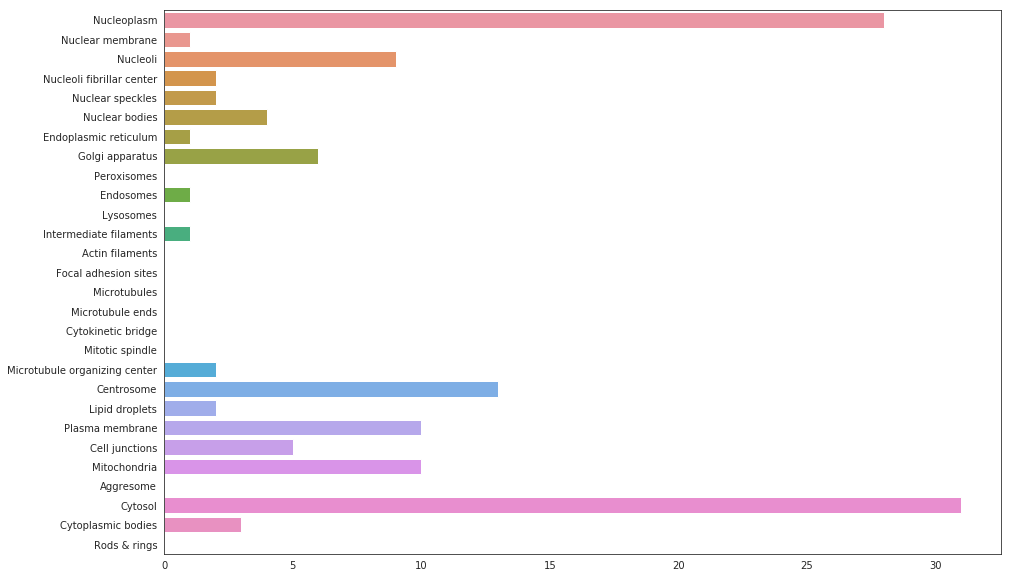

In [12]:
threshold = threshs # .5
predictions = predicts.max(1) # format_predictions(results)['predictions']


selected = predictions[1] > threshold[1]
idxs_mask = ~np.any(selected, axis=1)
selected[idxs_mask] = predictions[0][idxs_mask] > threshold[0]

idxs_mask = ~np.any(selected, axis=1)
predictions = predictions - threshs.reshape(2, 1, -1)
alpha = .4
predictions = alpha * predictions[0] + (1 - alpha) * predictions[1]
best_outs = np.argmax(predictions[idxs_mask], axis=1)
counts = np.zeros(shape=(len(config.label_names_list, )))
counts[:max(best_outs) + 1] = np.bincount(best_outs)

plt.figure(figsize=(15, 10))
sns.barplot(y=config.label_names_list, x=counts);
plt.show()

idxs = np.array(np.where(selected))
groups = npi.group_by(idxs[0]).split(idxs[1])

In [13]:
for idx, el in tqdm(zip(np.unique(idxs[0]), groups)):
    # test_datagen.dataset.labels.loc[idx, [label_names[e] for e in el]] = predictions[idx, el]
    test_dataset.labels.loc[idx, 'Predicted'] = ' '.join(['%d' % e for e in el])

11571it [00:11, 1001.09it/s]


In [14]:
test_dataset.labels['Id'] = test_dataset.labels.index
df = test_dataset.labels[['Id', 'Predicted']]
df.to_csv('simple.csv', index=False)